In [38]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr


/tmp/ipykernel_239655/3749613158.py:36: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [45]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
agents = ["DQN"]
games = ["QbertNoFrameskip-v4"]
# lrs = ["1.0e-04"]
lrs = ["1.0e-04"]
# seeds = ["32", "33", "34", "35", "36", "37"]
seeds = ["42", "43", "44", "45", "46"]
# betas = ["0.5", "0.8", "0.9", "0.999"]
betas = ["0.999"]
# dbs = ["-6.0"]
# lin_layers = ["2", "5"]
# optimizers = ["Adam", "AdamPlus", "AMSGrad", "Adan", "AdaBelief", "Adagrad", "AdaShift", "RMSprop", "Lion", "ADOPT"]
optimizers = ["Adam", "AdamPlus", "Adam+v2"]
exploration_fractions = ["0.05", "0.1"]
tss = ["1000", "8000", "80000"]

for csvfile in sorted(csvfiles):
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    # if len(cfgs) <= 6:
    #     continue
    # print(csvfile)
    env, agent, optimizer, learning_rate, beta2, seed = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5]
    training_starts = "100000"
    if len(cfgs) >= 8:
        training_starts = cfgs[7]
        if training_starts not in tss:
            continue
    if optimizer not in optimizers:
        continue
    if env not in games:
        continue
    if agent not in agents:
        continue
    if learning_rate not in lrs:
        continue
    if beta2 not in betas:
        continue
    if seed[-2:] not in seeds:
        continue
    # if lin_layer not in lin_layers:
    #     continue

    df_tmp = pd.read_csv(os.path.join(outdir, csvfile))
    df_tmp["time"] = df_tmp["runtime"].cumsum(axis=0)
    
    df_tmp['chunk'] = df_tmp['global_step'] // 1
    # df_chunked = df_tmp.groupby('chunk').agg({'return': 'mean',
    #                                           'EmaSNR': 'mean',
    #                                           'time': 'mean'
    #                                          }).reset_index()
    
    # df_chunked = df_chunked.rename(columns={'return': 'return_avg', 'EmaSNR': 'EmaSNR_avg', 'time': 'time_avg'})
    # df_tmp = df_chunked  
    
    df_tmp["env"] = cfgs[0]
    df_tmp["agent"] = cfgs[1]
    df_tmp["optimizer"] = cfgs[2]
    df_tmp["learning_rate"]=cfgs[3]
    df_tmp["beta2"]=cfgs[4]
    df_tmp["seed"]= seed
    # df_tmp["exploration_fraction"] = exploration_fraction
    df_tmp["training_starts"] = training_starts
    # df_tmp["lin_layer"] = lin_layer
  
    df = pd.concat([df, df_tmp], ignore_index=False)

    print(csvfile[0:-4])

# df = df.reset_index()
# epsilon = 1e-8
# df["m_sr_v"] = df["m"] / (np.sqrt(df["v"]) + epsilon)
# df["AdamPlusSNR"] = df["AdamPlusSNR"].replace([np.inf, -np.inf], 0)
# df["SNR"] = df["SNR"].fillna(0)
# df["EmaSNR"] = df["EmaSNR"].fillna(0)
df = df.reset_index(drop=True)
df

QbertNoFrameskip-v4_DQN_Adam+v2_1.0e-04_0.999_seed42_2
QbertNoFrameskip-v4_DQN_Adam+v2_1.0e-04_0.999_seed43_2
QbertNoFrameskip-v4_DQN_Adam+v2_1.0e-04_0.999_seed44_2
QbertNoFrameskip-v4_DQN_Adam+v2_1.0e-04_0.999_seed45_2
QbertNoFrameskip-v4_DQN_Adam+v2_1.0e-04_0.999_seed46_2
QbertNoFrameskip-v4_DQN_AdamPlus_1.0e-04_0.999_seed42_2
QbertNoFrameskip-v4_DQN_AdamPlus_1.0e-04_0.999_seed43_2
QbertNoFrameskip-v4_DQN_AdamPlus_1.0e-04_0.999_seed44_2
QbertNoFrameskip-v4_DQN_AdamPlus_1.0e-04_0.999_seed45_2
QbertNoFrameskip-v4_DQN_AdamPlus_1.0e-04_0.999_seed46_2
QbertNoFrameskip-v4_DQN_Adam_1.0e-04_0.999_seed42_2
QbertNoFrameskip-v4_DQN_Adam_1.0e-04_0.999_seed43_2
QbertNoFrameskip-v4_DQN_Adam_1.0e-04_0.999_seed44_2
QbertNoFrameskip-v4_DQN_Adam_1.0e-04_0.999_seed45_2
QbertNoFrameskip-v4_DQN_Adam_1.0e-04_0.999_seed46_2


,global_step,episode,return,SNR,EmaSNR,AdamPlusSNR,m,v,g,pwr_noise,...,lr,time,chunk,env,agent,optimizer,learning_rate,beta2,seed,training_starts
0,292,0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0001,5.432076e-01,292,QbertNoFrameskip-v4,DQN,Adam+v2,1.0e-04,0.999,seed42,100000
1,592,1,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0001,1.702507e+00,592,QbertNoFrameskip-v4,DQN,Adam+v2,1.0e-04,0.999,seed42,100000
2,876,2,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0001,3.225801e+00,876,QbertNoFrameskip-v4,DQN,Adam+v2,1.0e-04,0.999,seed42,100000
3,1196,3,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0001,5.158984e+00,1196,QbertNoFrameskip-v4,DQN,Adam+v2,1.0e-04,0.999,seed42,100000
4,1470,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0001,7.472265e+00,1470,QbertNoFrameskip-v4,DQN,Adam+v2,1.0e-04,0.999,seed42,100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126351,9994230,10182,15575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0001,4.803790e+08,9994230,QbertNoFrameskip-v4,DQN,Adam,1.0e-04,0.999,seed46,100000
126352,9994940,10183,3950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0001,4.805024e+08,9994940,QbertNoFrameskip-v4,DQN,Adam,1.0e-04,0.999,seed46,100000
126353,9995871,10184,4150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0001,4.806259e+08,9995871,QbertNoFrameskip-v4,DQN,Adam,1.0e-04,0.999,seed46,100000
126354,9997747,10185,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0001,4.807493e+08,9997747,QbertNoFrameskip-v4,DQN,Adam,1.0e-04,0.999,seed46,100000


In [46]:
df['chunk'] = df['chunk']/1000000

In [47]:
df = df.groupby(['chunk', 'env', 'agent', 'optimizer', 'learning_rate', 'beta2', 'training_starts']).agg(
    return_avg=('return', 'mean') 
).reset_index()

In [48]:
df = df.rename(columns={"return_avg": "return"})

In [49]:
df.loc[df['optimizer'] == 'AdamPlus', 'optimizer'] = 'Adam+ (No NI)'

output/fig/AdamPlus_QbertNoFrameskip-v4_seed36_return.pdf


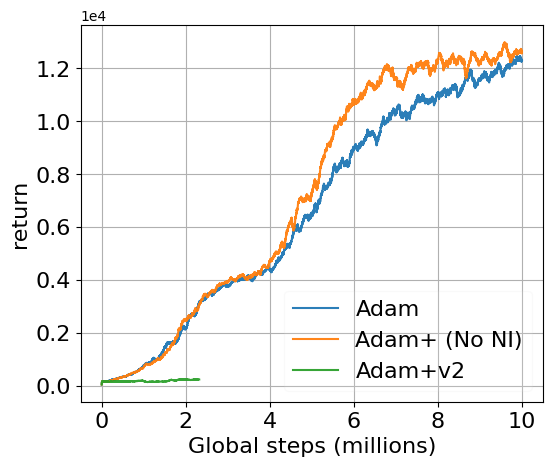

In [50]:
items = ["return"]
seedstr = 'seed36'

df_tmp = df

# df_tmp = df_tmp.iloc[::1, :]

# df_tmp= df_tmp[df_tmp["beta2"]=="0.999"]
# df_tmp= df_tmp[df_tmp["training_starts"]=="8000"]
# df_tmp= df_tmp[df_tmp["gamma"]=="0.99"]
# df_tmp= df_tmp[df_tmp["learning_rate"]=="2.5e-04"]
# df_tmp= df_tmp[df_tmp["seed"]==seedstr]
# df_tmp= df_tmp[df_tmp["exploration_fraction"]=="0.1"]
# df_tmp= df_tmp[df_tmp["optimizer"]=="Adam"]
# df_tmp= df_tmp[(df_tmp["batch_size"]=="1000")]
# df_tmp= df[df["env"]=="lander"]
for item in items: 
# for item in ["score", "pwr_noise", "m", "g"]: 
    fname = 'output/fig/AdamPlus_{}_{}_{}.pdf'.format(games[0], seedstr, item)
    # fname = '../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))

    alpha = 0.0025  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["optimizer", "beta2"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )
    
    # sns.lineplot(
    #     data=df_tmp, 
    #     x="chunk", 
    #     y=item, 
    #     hue="optimizer",
    #     hue_order=["Adam", 
    #                "AdamPlus", 
    #                #"AMSGrad", 
    #                #"Adan", 
    #                #"AdaBelief", 
    #                #"Adagrad", 
    #                #"AdaShift", 
    #                #"RMSprop", 
    #                #"Lion", 
    #                #"ADOPT"
    #             #    "Adam4"
    #               ],
    #     # style="agent",
    #     # style_order=["DQN", "VanillaDQN"],
    #     style="beta2",
    #     style_order=['0.999'],
    #     palette="tab10", 
    #     errorbar=None,
    #     markers=["o", "s", "D", "^"],
    #     markevery=100,
    #     # markersize=14,
    #     # dashes=False,
    #     # linestyle="dotted",
    #     alpha=0.1,
    #     linewidth=1.0,
    #     ax=ax,
    #     legend=False
    # )
    
    sns.lineplot(
        data=df_tmp,
        x="chunk",
        y=ema_col,
        hue="optimizer",
        # style="beta2",
        # style_order=['0.999'],
        hue_order=["Adam", 
                   "Adam+ (No NI)",
                   "Adam+v2"
                #    "AdamC", 
                   #"AMSGrad", 
                   #"Adan", 
                   #"AdaBelief", 
                   #"Adagrad", 
                   #"AdaShift", 
                   #"RMSprop", 
                   #"Lion", 
                   #"ADOPT"
                #    "Adam4"
                  ],
        palette='tab10',
        errorbar=None,
        ax=ax,
        linewidth=1.5,
        alpha=0.95,
        # legend=False,  # avoid duplicate legend entries
    )    
        
    
    L = ax.legend(
        fontsize=16,
        framealpha=0.1,
        ncol=1,
        # loc='upper right',
        # loc='lower right',
    )

    if item in ["m_sr_v"]:
        plt.yscale("log")
    # plt.xscale('log')
    # ax.set_ylim([-2, 25])
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
    # ax.set_xlim([0, 100])
    ax.grid(True)
    ax.set_xlabel('Global steps (millions)', fontsize=16)
    ax.set_ylabel(item, fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    print(fname)
    fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    # fig.savefig(fname,
    #             dpi=300,  # facecolor='w', edgecolor='w',
    #             orientation='portrait',
    #             format='pdf')


In [16]:
# df.to_csv(os.path.join(outdir, "cartpole_DQN_Adam_AdamPlus_betas_2025_04_10.csv"))
# df.to_csv(os.path.join(outdir, "cartpole_VanillaDQN_Adam_AdamPlus_betas_2025_04_10_corrected.csv"))
df.to_csv(os.path.join(outdir, "{}_VanillaDQN_Adam_AdamPlus_betas_2025_04_12_lr_decay_0.93_100.csv".format(games[0])))

In [6]:
env_name = 'cartpole'

file_dict_adam = {f'K50_seed{seed}': f'output/{env_name}_seed{seed}_DDQN_Adam.txt' for seed in range(42, 52)}
file_dict_adam_plus = {f'K50_seed{seed}': f'output/{env_name}_seed{seed}_DDQN_AdamPlus.txt' for seed in range(42, 52)}

In [29]:
def cifar_log_to_csv(log_text):
    
    pattern = r"\[(\d+),\s+(\d+)\] loss_tr: ([\d.]+) loss_te: ([\d.]+) acc_tr: ([\d.]+) acc_te: ([\d.]+)"
    data = re.findall(pattern, log_text)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["epoch", "samples", "loss_tr", "loss_te", "acc_tr", "acc_te"])
    df = df.astype({
        "epoch": int,
        "samples": int,
        "loss_tr": float,
        "loss_te": float,
        "acc_tr": float,
        "acc_te": float
    })
    return df

In [57]:
outdir2="../cifar-classifier/output/"
txtfiles = os.listdir(outdir2)
df = pd.DataFrame([])
for txtfile in txtfiles:
    fullpath = os.path.join(outdir2, txtfile)
    with open(fullpath, 'r') as f:
        log_text = f.read()
    df_tmp = cifar_log_to_csv(log_text)
    df_tmp["file"]=txtfile[0:-14]
    df_tmp["mini_batch"] = df_tmp["epoch"]*400 + df_tmp["samples"]
    df = pd.concat([df, df_tmp], ignore_index=False)

df = df.reset_index(drop=True)
df

,epoch,samples,loss_tr,loss_te,acc_tr,acc_te,file,mini_batch
0,0,100,2.116,1.883,0.222,0.324,adam+_th_-10dB_nj_-60dB,100
1,0,200,1.792,1.714,0.350,0.367,adam+_th_-10dB_nj_-60dB,200
2,0,300,1.659,1.582,0.399,0.422,adam+_th_-10dB_nj_-60dB,300
3,0,400,1.606,1.564,0.417,0.434,adam+_th_-10dB_nj_-60dB,400
4,1,100,1.493,1.480,0.471,0.468,adam+_th_-10dB_nj_-60dB,500
...,...,...,...,...,...,...,...,...
1155,48,400,0.343,2.113,0.877,0.614,adam+_th_-3dB,19600
1156,49,100,0.284,2.111,0.899,0.606,adam+_th_-3dB,19700
1157,49,200,0.303,2.139,0.888,0.605,adam+_th_-3dB,19800
1158,49,300,0.313,2.124,0.888,0.617,adam+_th_-3dB,19900


../fig/AdamPlus_CIFAR_image_classification_loss_tr.pdf
../fig/AdamPlus_CIFAR_image_classification_loss_te.pdf
../fig/AdamPlus_CIFAR_image_classification_acc_tr.pdf
../fig/AdamPlus_CIFAR_image_classification_acc_te.pdf


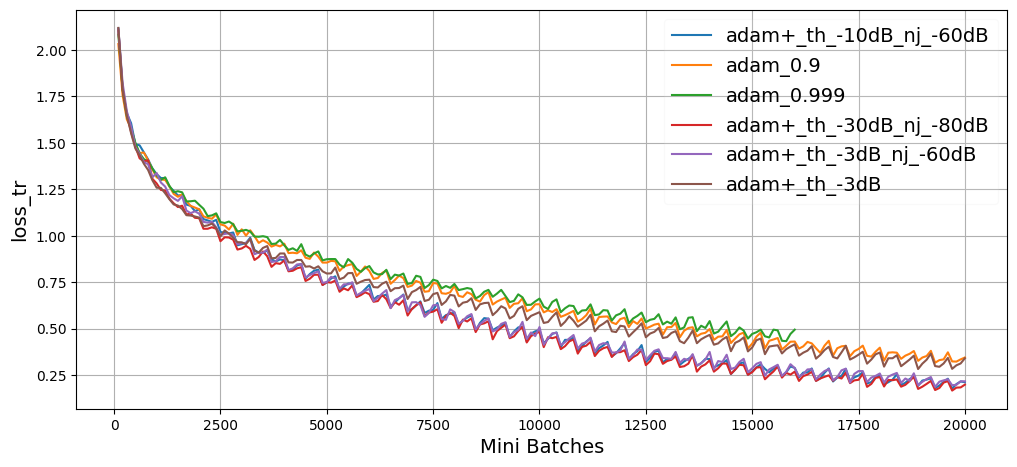

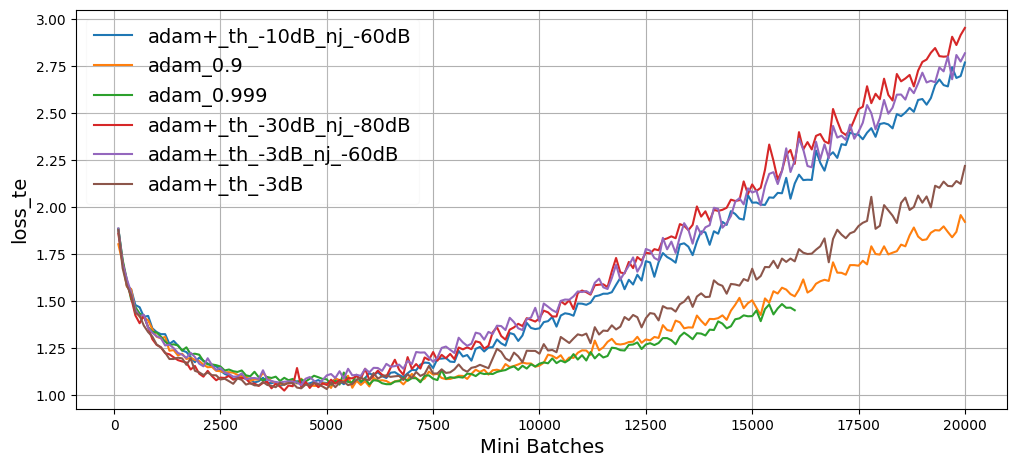

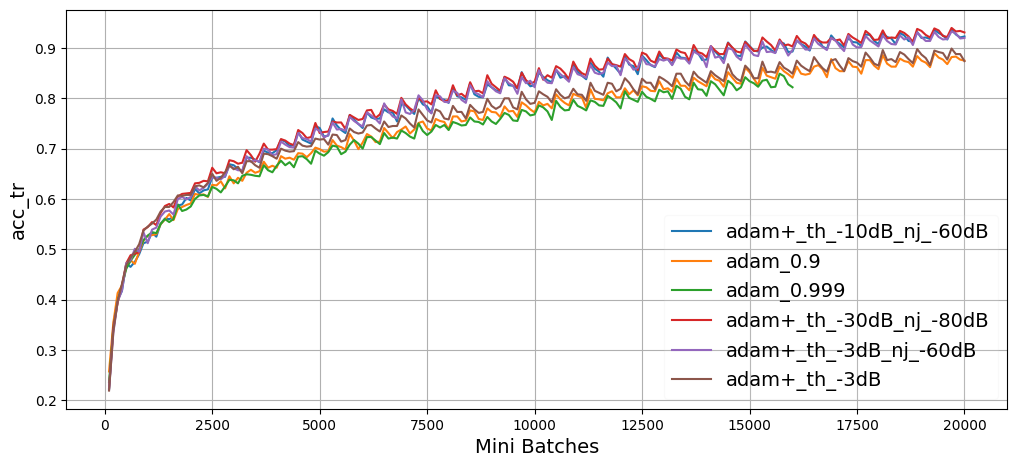

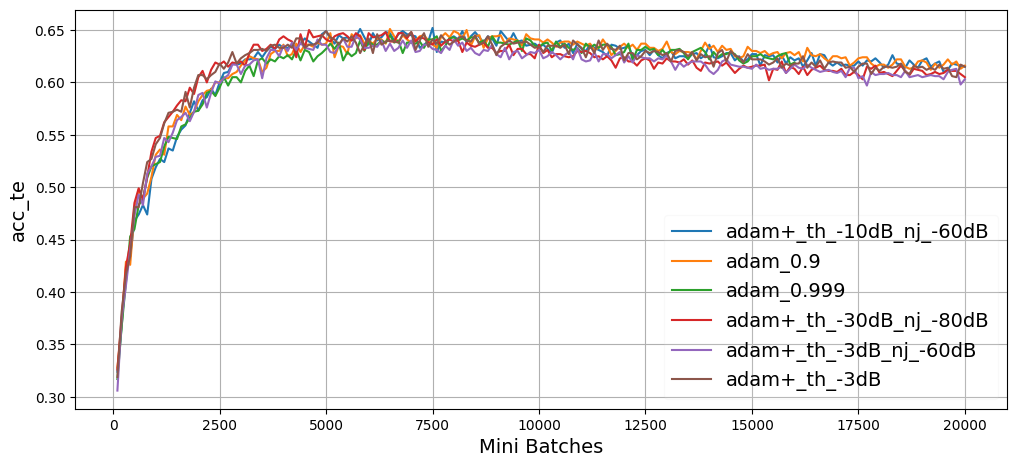

In [58]:
item = "score"
task = "CIFAR_image_classification"

df_tmp = df
# df_tmp= df_tmp[df_tmp["beta2"]=="0.9"]
# df_tmp= df_tmp[df_tmp["seed"]=="seed35"]
# df_tmp= df[df["env"]=="lander"]
# for item in ["score", "EmaSNR", "AdamPlusSNR"]: 
for item in ["loss_tr", "loss_te", "acc_tr", "acc_te"]: 
    fname = '../fig/AdamPlus_{}_{}.pdf'.format(task, item)
    # fname = '../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))
    
    sns.lineplot(
        data=df_tmp, 
        x="mini_batch", 
        # x="time", 
        y=item, 
        hue="file",
        # hue_order=["Adam","AdamPlus", "AMSGrad"],
        # style="agent",
        # style_order=["DQN", "VanillaDQN"],
        # style="beta2",
        # style_order=["0.9","0.99","0.999"],
        palette="tab10", 
        errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        ax=ax,
    )
    
    
    
    L = ax.legend(
        fontsize=14,
        framealpha=0.1,
        ncol=1,
        # loc='upper right',
    #     loc='lower right',
    )

    if item in ["m_sr_v"]:
        plt.yscale("log")
    # ax.set_ylim([-2, 25])
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
    # ax.set_xlim([0, 5000])
    ax.grid(True)
    ax.set_xlabel('Mini Batches', fontsize=14)
    ax.set_ylabel(item, fontsize=14)
    
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')
